### General Optimisation of Input Tokens 

In [1]:
from inseq import load_model
import torch
import torch.nn.functional as F
# Load model with gradient-based attribution
model = load_model(model="gpt2", attribution_method="saliency", device="cuda" if torch.cuda.is_available() else "cpu")
embedding_layer = model.model.get_input_embeddings()


c:\Users\Kalai\anaconda3\envs\XAI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Kalai\anaconda3\envs\XAI\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [2]:
def optimize_toward_target(input_text, target_token, step) : 
    """Change the input tokens in such way that the probability of getting the target_token is increased.
    The optimization is done for all input tokens at once (in parallel)

    Args:
        input_text (_type_): sequence of input text (str)
        target_token (_type_): the next token that amy be given by the model to compete the input text (str)
        step (_type_): factor by which the gradient is multiplied to move in the embedding space (int)

    Returns:
        _type_: new sequence of input text (str)
    """

    # Convert input text to token 
    inputs = model.tokenizer(input_text, return_tensors="pt")
    target_token = model.tokenizer.tokenize(" " + target_token.strip()) # make sur the target output word starts with a space to ahve a recognised token
    if len(target_token) == 1: 
        target_token = target_token[0]
    else: 
        print(f"Several tokens have been assigned to the target output word: {target_token}.")
        return None
    target_id = model.tokenizer.convert_tokens_to_ids(target_token) # convert the target token to ID

    # # For optimizing toward a phrase:
    # target_ids = [model.tokenizer.convert_tokens_to_ids(t) for t in ["lazy", "dog"]]
    # target_logits = sum(outputs.logits[0, -len(target_ids):, target_ids].diag())

    # Stop if target token is not part of the vocabulary of gpt2
    if target_id == model.tokenizer.unk_token_id:
        print(f"Warning: Target token '{target_token}' not found in vocabulary. Using UNK ID ({target_id}). Results might not be meaningful.")
        return None

    # Perform forward pass with gradient tracking
    with torch.set_grad_enabled(True):
        # Get embeddings and mark as requiring gradients (so that we retain the gradient for non-leaf tensors)
        embeddings = embedding_layer(inputs.input_ids)
        embeddings.retain_grad()
        embeddings.requires_grad_(True)
        
        # Forward pass through model
        outputs = model.model(
            inputs_embeds=embeddings,
            attention_mask=inputs.attention_mask
        )
        
        # Get logits for the target position (next token prediction)
        target_position = -1  # Position after last input token
        target_logit = outputs.logits[0, target_position, target_id]
        
        # Compute gradients d(logit)/d(embeddings)
        target_logit.backward()
        gradients = embeddings.grad.clone()

    # Modify embeddings with gradients
    # print("Comuted Gradients: ", gradients)
    for i in range(len(gradients[0])) : 
        gradients[0][i] = gradients[0][i] / (sum(abs(i) for i in gradients[0][i])) # compute 1 step gradient (divide by norm the gradient)

    modified_embeddings = embeddings + gradients*step

    # Nearest Neighbor Search
    all_embeddings = embedding_layer.weight #Vocab Embeddings; all tokens in vocabulary
    new_token_ids = []
    for i, emb in enumerate(modified_embeddings[0]) : 
        # find closest token in voc. Best to use cos similarity as it will ignore the magnitude of the embeddings and focus on the direction
        # cos(a, b) = (a . b) / (||a|| * ||b||)
        distances = F.cosine_similarity(emb, all_embeddings, dim=-1)

        # # Euclidean distance 
        # distances = -torch.norm(all_embeddings - emb, dim=1)
        # # Dot product (ignore magnitude normalization here)
        # distances = torch.matmul(all_embeddings, emb)

        new_id = torch.argmax(distances).item()
        new_token_ids.append(new_id)

    #Decode the new tokens
    new_tokens = model.tokenizer.convert_ids_to_tokens(new_token_ids)
    new_text = model.tokenizer.convert_tokens_to_string(new_tokens)
    print(f"Original text: {input_text}")
    print(f"Modified text: {new_text}")


    # Compare Probabilities
    with torch.no_grad():
        modified_outputs = model.model(
            inputs_embeds=modified_embeddings,
            attention_mask=inputs.attention_mask
        )
        original_probs = torch.softmax(outputs.logits[0, target_position], dim=-1)
        modified_probs = torch.softmax(modified_outputs.logits[0, target_position], dim=-1)

    print(f"Original probability of '{target_token}': {original_probs[target_id].item():.10f}")
    print(f"Modified probability of '{target_token}': {modified_probs[target_id].item():.10f}")

    return new_text


### Specific Input Token Optimisation

In [7]:
from inseq import load_model
import torch
import torch.nn.functional as F
import random
# Load model with gradient-based attribution
# there is: gpt2, gpt2-medium, gpt2-large, gpt2-xl
model = load_model(model="gpt2", attribution_method="saliency", device="cuda" if torch.cuda.is_available() else "cpu")
embedding_layer = model.model.get_input_embeddings()


c:\Users\Kalai\anaconda3\envs\XAI\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


#### Histogram Plot

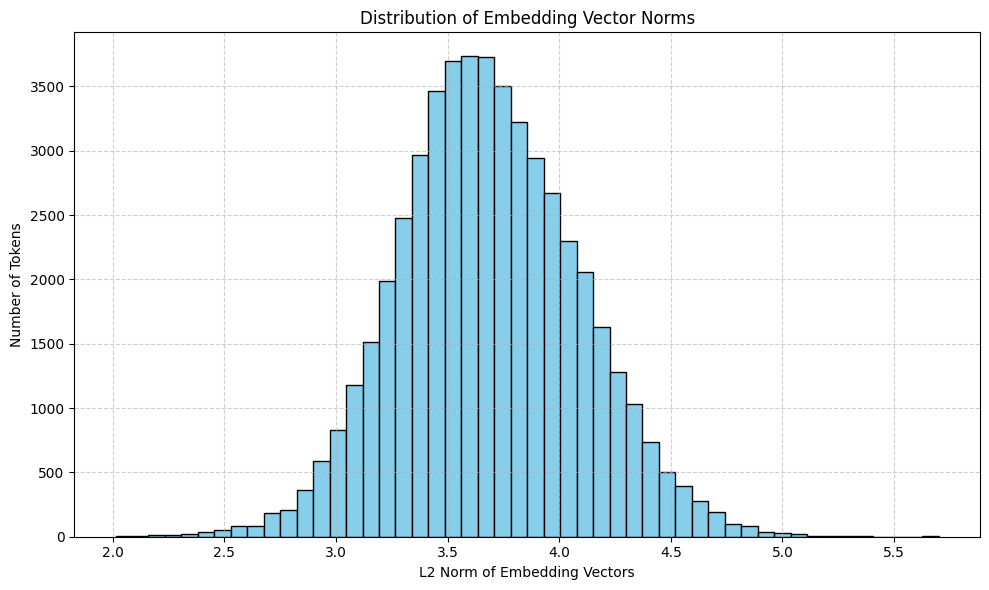

In [69]:
# plot histogram
import torch
import matplotlib.pyplot as plt

def plot_embedding_norm_histogram(embedding_layer, bins=50):
    """
    Plot a histogram of vector norms from the embedding layer.

    Args:
        embedding_layer (torch.nn.Embedding): The embedding layer of the model.
        bins (int): Number of histogram bins.
    """

    # Get all token embeddings
    embeddings = embedding_layer.weight.detach().cpu()  # shape: [vocab_size, embedding_dim]

    # Compute L2 norms for each embedding vector
    norms = torch.norm(embeddings, p=2, dim=1).numpy()  # shape: [vocab_size]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(norms, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Distribution of Embedding Vector Norms")
    plt.xlabel("L2 Norm of Embedding Vectors")
    plt.ylabel("Number of Tokens")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_embedding_norm_histogram(embedding_layer=embedding_layer)

In [2]:
from transformers import GPT2Model, GPT2Tokenizer

# Load model and tokenizer
model = GPT2Model.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Access the embedding layer
embedding_layer = model.get_input_embeddings()

# Get size: (vocab_size, embedding_dim)
embedding_size = embedding_layer.weight.shape
print(f"Embedding matrix size: {embedding_size}")
print(f"Embedding dimension: {embedding_size[1]}")

Embedding matrix size: torch.Size([50257, 768])
Embedding dimension: 768


#### Standard Gradient Method

In [ ]:
def pre_process(target_token):
    
    target_token = model.tokenizer.tokenize(" " + target_token.strip()) # make sur the target output word starts with a space to ahve a recognised token
    if len(target_token) == 1: 
        target_token = target_token[0]
    else: 
        print(f"Several tokens have been assigned to the target output word: {target_token}.")
        return None
    target_id = model.tokenizer.convert_tokens_to_ids(target_token) # convert the target token to ID

    if target_id == model.tokenizer.unk_token_id:
        print(f"Warning: Target token '{target_token}' not found in vocabulary. Using UNK ID ({target_id}). Results might not be meaningful.")
        return None

    return target_token, target_id

def compute_grad(inputs, target_id):
    with torch.set_grad_enabled(True):
        # Get embeddings and mark as requiring gradients (so that we retain the gradient for non-leaf tensors)
        embeddings = embedding_layer(inputs.input_ids)
        embeddings.retain_grad()
        embeddings.requires_grad_(True)
    
        # Forward pass through model
        outputs = model.model(
            inputs_embeds=embeddings,
            attention_mask=inputs.attention_mask
        )
        # Get logits for the target position (next token prediction)
        # target_position = -1  # Position after last input token
        target_logit = outputs.logits[0, -1, target_id]
        
        # Compute gradients d(logit)/d(embeddings)
        target_logit.backward()
        gradients = embeddings.grad.clone()
    
    return embeddings, gradients, outputs

def get_new_token(modified_embeddings, token_input_position, inputs, distance_type): 
    # Nearest Neighbor Search
    all_embeddings = embedding_layer.weight #Vocab Embeddings; all tokens in vocabulary
    new_token_ids = []
    if distance_type == "cosine_similarity":
        distances = F.cosine_similarity(modified_embeddings[0][token_input_position], all_embeddings, dim=-1)
    elif distance_type == "dot_product": 
        distances = torch.matmul(all_embeddings, modified_embeddings[0][token_input_position])
    elif distance_type == "euclidean" : 
        distances = -torch.norm(all_embeddings - modified_embeddings[0][token_input_position], dim=1) # take "-" because it is a distance metric so smaller values mean better but it is the opposite for sim. metrics (cos. sim., dot. prod.)
    elif distance_type == "manhattan" : 
        distances = -torch.sum(torch.abs(all_embeddings - modified_embeddings[0][token_input_position]), dim=1)
    new_id = torch.argmax(distances).item()
    new_token_ids.append(new_id)
    inputs['input_ids'][0][token_input_position] = new_token_ids[0]
    new_token_ids = inputs['input_ids']

    new_token = model.tokenizer.convert_ids_to_tokens(new_id) # for plot

    #Decode the new tokens
    new_tokens = model.tokenizer.convert_ids_to_tokens(new_token_ids[0])
    new_text = model.tokenizer.convert_tokens_to_string(new_tokens)
    return new_token, new_tokens, new_text

def optimize_single_input_token_toward_target(input_text, target_token, step,
                                               n_iteration, token_input_position, distance_type="cosine_similarity", 
                                               random_dir = False, opposite_dir=True, grad=None) : 

    target_token, target_id = pre_process(target_token)
    original_text = input_text

    for i in range(n_iteration) :
        
        inputs = model.tokenizer(original_text, return_tensors="pt")
        embeddings, gradients, outputs = compute_grad(inputs, target_id)

        if grad == None: 
            for i in range(len(gradients[0])) : 
                gradients[0][i] = gradients[0][i] / (sum(abs(i) for i in gradients[0][i]))
        else: 
            gradients[0][token_input_position] = grad
        
        # print("HERE GRADIENTS: ", gradients)
        if opposite_dir == True : 
            gradients *=-1

        elif random_dir == True: 
            random.shuffle(gradients[0][token_input_position]) # shuffle the gradient of the input token to optimise

        modified_embeddings = embeddings
        modified_embeddings[0][token_input_position] += gradients[0][token_input_position]*step
        # + 0.9*(gradients[0].mean(dim=0)) #consider the context (0.5*mean of the input embeddings)

        new_token, new_tokens, new_text = get_new_token(modified_embeddings, token_input_position, inputs, distance_type)
        
        # print(f"Original text: {original_text}")
        # print(f"Modified text: {new_text}")

        # Compare Probabilities
        with torch.no_grad():
            modified_outputs = model.model(
                inputs_embeds=modified_embeddings,
                attention_mask=inputs.attention_mask
            )
            original_probs = torch.softmax(outputs.logits[0, -1], dim=-1) # -1 corresponds to the target position: the last token, the token to be generated
            modified_probs = torch.softmax(modified_outputs.logits[0, -1], dim=-1)

        # print(f"Original probability of '{target_token}': {original_probs[target_id].item():.10f}")
        # print(f"Modified probability of '{target_token}': {modified_probs[target_id].item():.10f}")

        original_text = new_text

    return new_text, [modified_probs[target_id].item(), new_token], gradients


In [ ]:
# get the gradient for "black": 

text_black, logits_black, gradients_black = optimize_single_input_token_toward_target(input_text="That black woman is", target_token="beautiful", step=1, 
                                                                                                token_input_position=1, n_iteration=1, opposite_dir=False, 
                                                                                                distance_type="euclidean", grad=None, random_dir=False)


text_white, logits_white, gradients_white = optimize_single_input_token_toward_target(input_text="That white woman is", target_token="beautiful", step=1, 
                                                                                                token_input_position=1, n_iteration=1, opposite_dir=False, 
                                                                                                distance_type="euclidean", grad=None, random_dir=False)

gradient_black = gradients_black[0][1]
gradient_white = gradients_white[0][1]

gradient_to_white = gradient_white - gradient_black

# normalise

gradient_norm = torch.norm(gradient_to_white)

gradient_to_white = gradient_to_white/gradient_norm


In [ ]:
for i in range(len(gradient_to_white)) : 
    gradient_to_white[i] = gradient_to_white[i]/torch.norm()

tensor(0.0293)

In [60]:

def get_plot_data(steps, input_text, input_token_pos,  target_token, random_dir=False, opposite_dir=False, compute_distance="cosin_similarity", explore_radius=False, gradient=None) :
    data_plot = {}
    for step in range(steps) : 
        step  = 1 if explore_radius==True else step # Explore a radius of 1 around the initial embedding, take random directions
        if opposite_dir == True: 
                new_text, data_plot[step], gradients = optimize_single_input_token_toward_target(input_text=input_text, target_token=target_token, step=step, 
                                                                                                token_input_position=input_token_pos, n_iteration=1, opposite_dir=opposite_dir, 
                                                                                                distance_type=compute_distance, grad=gradient, random_dir=random_dir)
        else:
                new_text, data_plot[step], gradients = optimize_single_input_token_toward_target(input_text=input_text, target_token=target_token, step=step, 
                                                                                                token_input_position=input_token_pos, n_iteration=1, opposite_dir=opposite_dir, 
                                                                                             distance_type=compute_distance, grad=gradient, random_dir=random_dir)
    return new_text, data_plot, gradients

new_text, data_plot, gradients = get_plot_data(steps=500, input_text="Stop that fox from", input_token_pos = 2,
                                               target_token="barking", compute_distance="euclidean", opposite_dir=True)

In [152]:
# Change input

original_text = "Stop that fox from"
text = original_text
iterations = 501
results = []
while iterations > 0 :
    if iterations%100==0: 
        print("STEP: ", iterations)
    iterations -=1
    if text != original_text :
        print("NEW INPUT TEXT: ", text)
        iterations = 501
        original_text = text
    text, data_plot[(text, iterations)], gradients =  optimize_single_input_token_toward_target(input_text=text, target_token="barking", step=iterations-500, 
                                                                                                token_input_position=2, n_iteration=1, opposite_dir=False, 
                                                                                                distance_type="euclidean", grad=None, random_dir=False)
    results.append(data_plot)

STEP:  500
STEP:  400
STEP:  300
STEP:  200
NEW INPUT TEXT:  Stop that Miz from
STEP:  500
STEP:  400
STEP:  300
STEP:  200
NEW INPUT TEXT:  Stop that Wrest from
STEP:  500
STEP:  400
STEP:  300
STEP:  200
NEW INPUT TEXT:  Stop that Kid from
STEP:  500
STEP:  400
NEW INPUT TEXT:  Stop that arrested from
STEP:  500
STEP:  400
STEP:  300
NEW INPUT TEXT:  Stop that stopped from
STEP:  500
STEP:  400
NEW INPUT TEXT:  Stop that started from
STEP:  500
STEP:  400
STEP:  300
NEW INPUT TEXT:  Stop that runs from
STEP:  500
STEP:  400
NEW INPUT TEXT:  Stop that spans from
STEP:  500
STEP:  400
NEW INPUT TEXT:  Stop that lasts from
STEP:  500
STEP:  400
STEP:  300
STEP:  200
STEP:  100
NEW INPUT TEXT:  Stop that popup from
STEP:  500
STEP:  400
STEP:  300
NEW INPUT TEXT:  Stop that cafe from
STEP:  500
STEP:  400
STEP:  300
NEW INPUT TEXT:  Stop that restaurant from
STEP:  500
STEP:  400
NEW INPUT TEXT:  Stop that disrespectful from
STEP:  500
STEP:  400
STEP:  300
NEW INPUT TEXT:  Stop that dis

In [157]:
save_results = results.copy()

In [158]:
results[:10]

[{1: [0.0006141085177659988, 'Ġfox'],
  ('Stop that fox from', 500): [0.0005907803424634039, 'Ġfox'],
  ('Stop that fox from', 499): [0.000564098299946636, 'Ġfox'],
  ('Stop that fox from', 498): [0.0005356090259738266, 'Ġfox'],
  ('Stop that fox from', 497): [0.0005066992598585784, 'Ġfox'],
  ('Stop that fox from', 496): [0.0004784944758284837, 'Ġfox'],
  ('Stop that fox from', 495): [0.0004517153720371425, 'Ġfox'],
  ('Stop that fox from', 494): [0.00042680022306740284, 'Ġfox'],
  ('Stop that fox from', 493): [0.0004038997576572001, 'Ġfox'],
  ('Stop that fox from', 492): [0.00038307509385049343, 'Ġfox'],
  ('Stop that fox from', 491): [0.00036424986319616437, 'Ġfox'],
  ('Stop that fox from', 490): [0.0003472799144219607, 'Ġfox'],
  ('Stop that fox from', 489): [0.00033198943128809333, 'Ġfox'],
  ('Stop that fox from', 488): [0.000318172707920894, 'Ġfox'],
  ('Stop that fox from', 487): [0.00030567904468625784, 'Ġfox'],
  ('Stop that fox from', 486): [0.00029429190908558667, 'Ġfox']

In [ ]:
import pandas as pd
df_all = pd.DataFrame()
for elem in range(len(results)) :
    if elem%1000 == 0:
        print("STEP: ", elem)
    local_data = results[elem]
    df = pd.DataFrame.from_dict(local_data, orient='index', columns=["Probability", "Token"])
    df.index.name = "Step"
    df_all = pd.concat([df_all, df])
    

STEP:  0
STEP:  1000


In [45]:
# Random directions (5 DIRECTIONS) 
# need gradient

data_plot_random = {}
for j in range(5) :
    gradients = get_plot_data(steps=1, input_text="Stop that fox from", input_token_pos = 2,
                                               target_token="barking", compute_distance="manhattan")[-1] # get the gradient
    random.shuffle(gradients[0][2]) #gradient randomisation
    # print(f"Gradient randomisation: {gradients[0][2]}")
    data_plot_random[f"random_dir_{j}"] = get_plot_data(steps=500, input_text="Stop that fox from", input_token_pos = 2,
                                                        target_token="barking", compute_distance="cosine_similarity", gradient=gradients)[1]

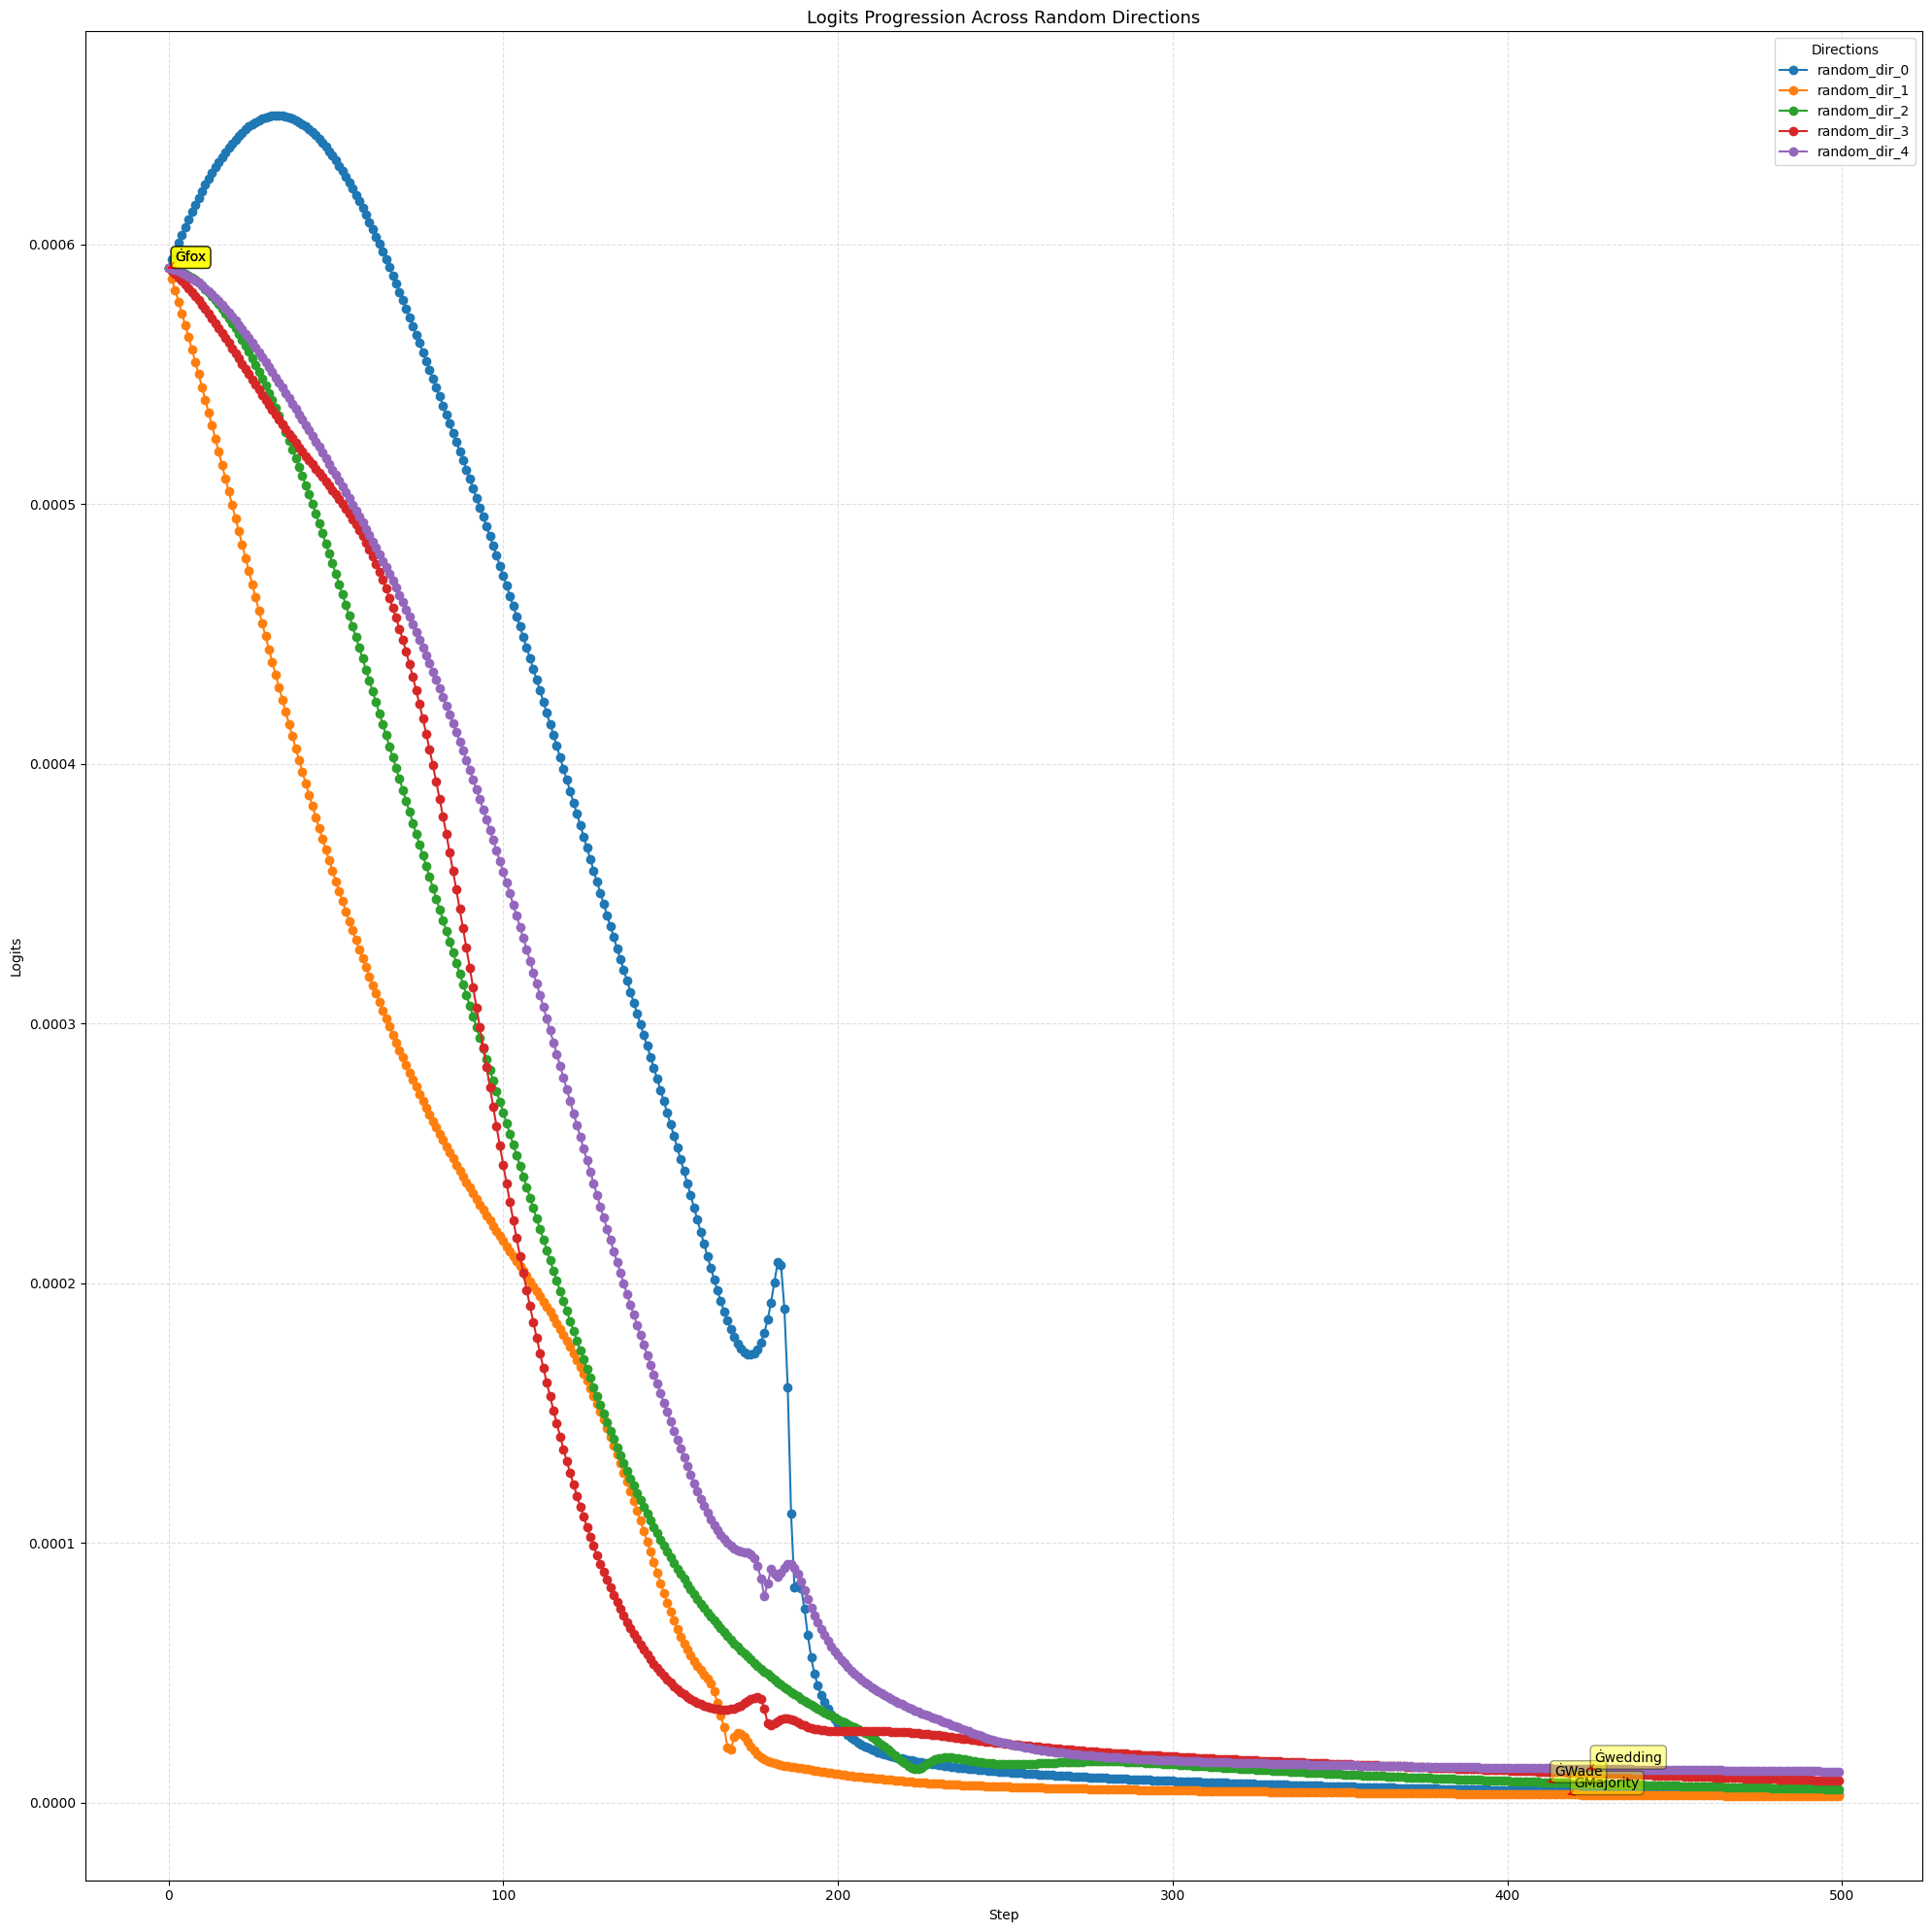

In [ ]:
# For multiple directions at once

import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(20,20))

for label, steps_dict in data_plot_random.items() : 
    df = pd.DataFrame.from_dict(steps_dict, orient="index", columns=['Logits', 'Token'])
    df.index.name = "Step"

    plt.plot(df.index, df["Logits"], marker='o', linestyle='-', label = label)

    prev_token = None
    for step, row in df.iterrows(): 
        current_token = row['Token']
        if current_token != prev_token: 
            plt.annotate(current_token,
                         xy=(step, row['Logits']), 
                         xytext=(5,5), 
                         textcoords="offset points",
                         bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.4),
                         arrowprops=dict(arrowstyle='->', color='red', lw=1))
            prev_token=current_token
    
plt.title("Logits Progression Across Random Directions", fontsize=13)
plt.xlabel("Step", fontsize=10)
plt.ylabel("Logits", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Directions')
plt.tight_layout()
plt.show()

In [50]:
import pandas as pd

df = pd.DataFrame.from_dict(data_plot_random, orient='index', columns=["Probability", "Token"])
df.to_csv("./data/5_random_dir_stop_that_FOX_from_cosine_similarity.csv", index=False)

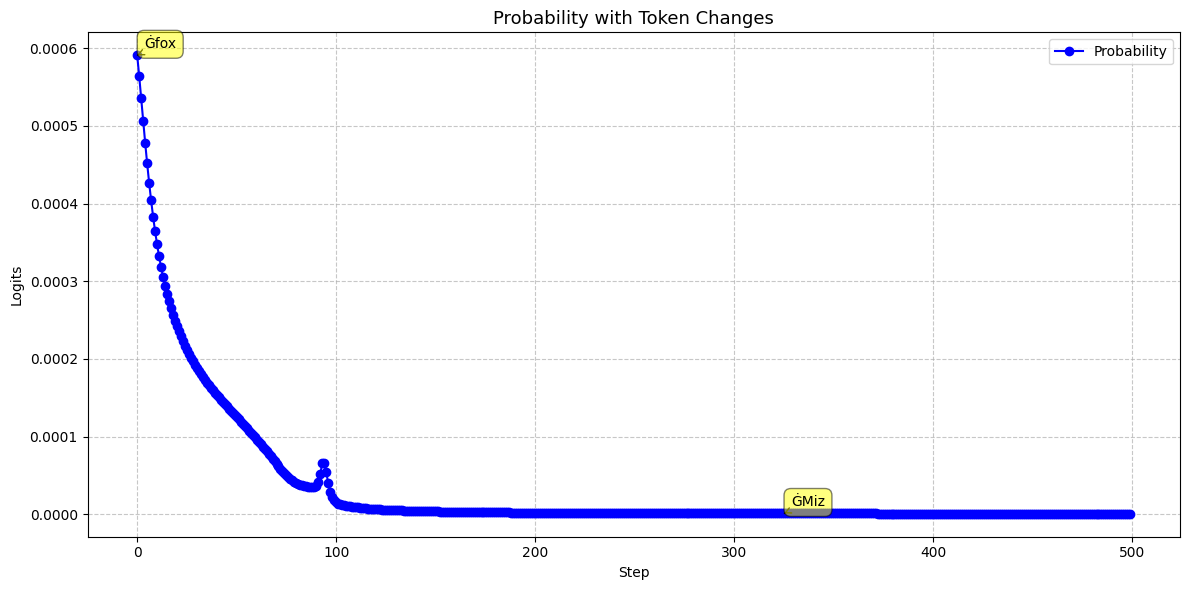

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame.from_dict(data_plot, orient='index', columns=["Probability", "Token"])
df.index.name = "Step"

plt.figure(figsize=(12,6))
line = plt.plot(df.index, df["Probability"], 
                marker='o', linestyle='-', color='b', label='Probability')

prev_token = None
for step, row in df.iterrows():
    current_token = row['Token']
    if current_token != prev_token : 
        plt.annotate(current_token, 
                     xy=(step, row["Probability"]), 
                     xytext=(5,5),
                     textcoords="offset points", 
                     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5), 
                     arrowprops=dict(arrowstyle='->'))
        
    prev_token=current_token

plt.title("Probability with Token Changes", fontsize=13)
plt.xlabel("Step", fontsize=10)
plt.ylabel("Logits", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7), 
plt.legend()

plt.tight_layout()
plt.show()
        

In [62]:
import pandas as pd

df = pd.DataFrame.from_dict(data_plot, orient='index', columns=["Probability", "Token"])
df.to_csv("./data/stop_that_FOX_from_barking_opposite_dir_euclidean.csv", index=False)

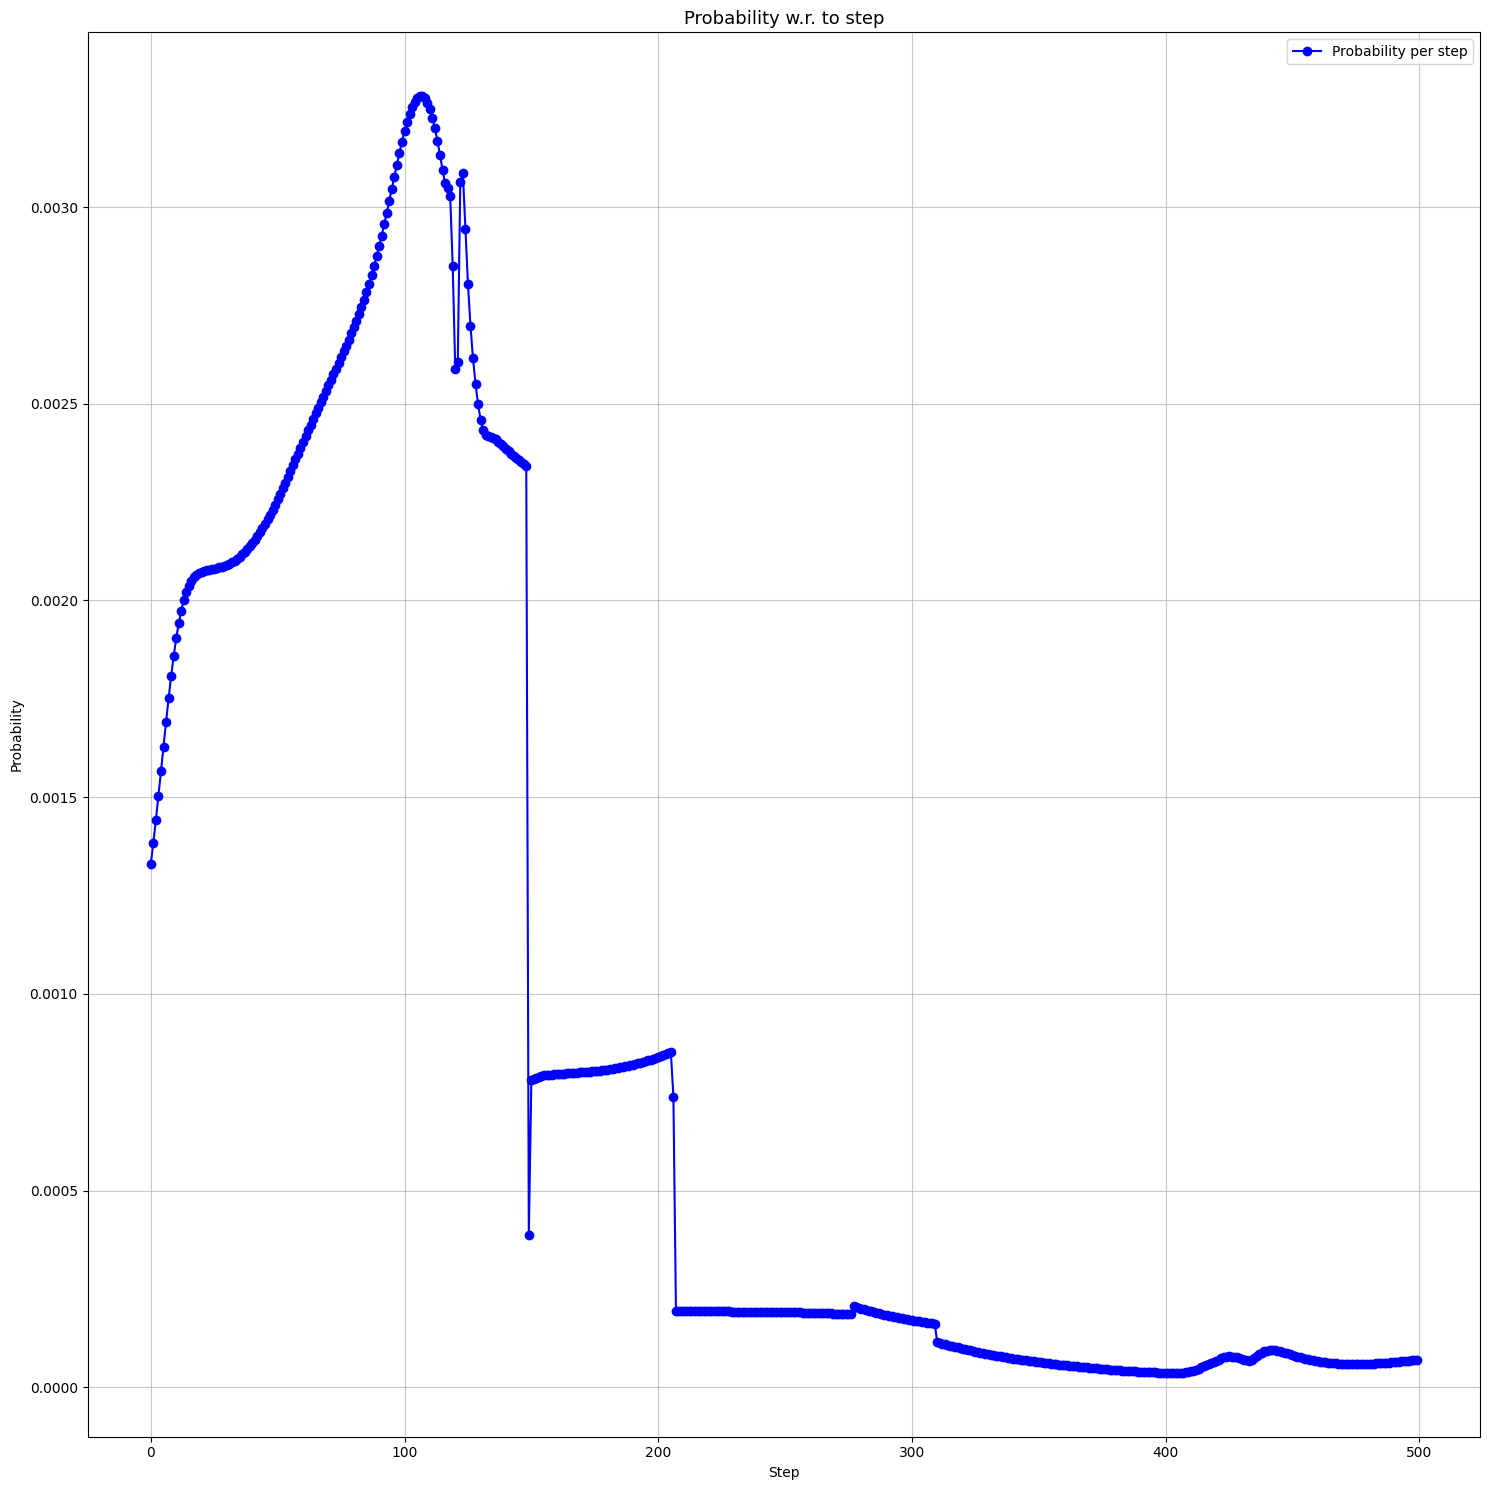

In [16]:
import matplotlib.pyplot as plt

steps = list(data_plot.keys())
probs = list(data_plot.values())

plt.figure(figsize=(15, 15))
plt.plot(steps,probs, marker='o', linestyle='-', color='b', label='Probability per step' )

plt.title('Probability w.r. to step', fontsize=13)
plt.xlabel("Step", fontsize=10)
plt.ylabel("Probability", fontsize=10)
plt.grid(True, linestyle="-", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
data_plot

{0: 0.0013306631008163095,
 1: 0.0013847675872966647,
 2: 0.0014424831606447697,
 3: 0.0015029883943498135,
 4: 0.001565443933941424,
 5: 0.0016285793390125036,
 6: 0.0016909169498831034,
 7: 0.001750969560816884,
 8: 0.0018071385566145182,
 9: 0.0018582356860861182,
 10: 0.0019033952848985791,
 11: 0.001942111412063241,
 12: 0.001974348910152912,
 13: 0.002000602660700679,
 14: 0.002021318068727851,
 15: 0.002037317957729101,
 16: 0.0020494863856583834,
 17: 0.002058451995253563,
 18: 0.0020649603102356195,
 19: 0.002069651847705245,
 20: 0.0020730483811348677,
 21: 0.002075373660773039,
 22: 0.0020770945120602846,
 23: 0.002078494755551219,
 24: 0.0020797590259462595,
 25: 0.00208091433160007,
 26: 0.002082215854898095,
 27: 0.002083835192024708,
 28: 0.0020857222843915224,
 29: 0.002087834058329463,
 30: 0.0020905649289488792,
 31: 0.00209370837546885,
 32: 0.0020972201600670815,
 33: 0.0021014027297496796,
 34: 0.002106020227074623,
 35: 0.0021112009417265654,
 36: 0.00211694953031

### Integrated Gradients Method


In [51]:
from inseq import load_model
import torch
import torch.nn.functional as F
# Load model with gradient-based attribution
model = load_model(model="gpt2", attribution_method="integrated_gradients", device="cuda" if torch.cuda.is_available() else "cpu")
embedding_layer = model.model.get_input_embeddings()


In [57]:
def optimize_specific_input_token_with_TRUE_IG_towards_target(input_text, target_token, input_token_pos, n_iteration, step): 
    
    target_token = " " + target_token.strip()
    target_token =  model.tokenizer.tokenize(target_token)[0]
    target_id = model.tokenizer.convert_tokens_to_ids(target_token[0])

    current_text = input_text
    for i in range(n_iteration) :  
        original_text = current_text
        output = model.attribute(
            current_text, 
            f"{current_text}{target_token[0]}", 
            attributed_fn="probability", 
            step_scores=["probability"],
            show_progress=False
        )


        grad =  output.sequence_attributions[0].target_attributions[input_token_pos]
        grad = grad /  (torch.norm(grad, p=1))

        inputs = model.tokenizer(current_text, return_tensors='pt')
        embeddings = model.model.get_input_embeddings()(inputs.input_ids)
        modified_embeddings = embeddings[0, input_token_pos] + step*grad

        all_embeddings = model.model.get_input_embeddings().weight
        
        distances  = F.cosine_similarity(modified_embeddings[0, input_token_pos], 
                                         all_embeddings,  
                                         dim=-1)
        new_id = torch.argmax(distances).item()
        new_token = model.tokenizer.convert_ids_to_tokens([new_id])[0]

        current_tokens = model.tokenizer.tokenize(current_text)
        # print("INPUT TOKENS: ", current_tokens)

        if (input_token_pos != 0) & (new_token[0] != "Ġ"): 
            new_token = "Ġ" + new_token

        current_tokens[input_token_pos] = new_token
        current_text = model.tokenizer.convert_tokens_to_string(current_tokens)
        # print("DEBUG: ", new_token)


        orig_prob = output.sequence_attributions[0].step_scores['probability'][0].item()
        new_output = model.attribute(
            current_text,
            f"{current_text}{target_token[0]}",
            attributed_fn="probability",
            step_scores=["probability"],
            show_progress=False, 
        )
        new_prob = new_output.sequence_attributions[0].step_scores["probability"][0].item()
        
        print(f"Modified: {model.tokenizer.tokenize(original_text)[input_token_pos]} → {new_token}")
        print(f"Full text: {current_text}")
        print(f"P({target_token}): {orig_prob:.10f} → {new_prob:.10f} ({'↑' if new_prob > orig_prob else '↓'})")

    return new_prob, new_token

        


In [ ]:
# Explore random directions
# Explore Opposite Direction
# Hist Plot about distribution of norms of embedding space
# Explain clearly Ingetgrated Gradients
# 

In [59]:
input_text = "that black woman is"
target_token = "pretty" 
data_IG_plot = {}

for step in range(100):
    data_IG_plot[step] = optimize_specific_input_token_with_TRUE_IG_towards_target(input_text=input_text, target_token=target_token, input_token_pos=1, n_iteration=1, step=step)

Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.0000000184 → 0.0000010718 (↑)
Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.0000000184 → 0.0000010718 (↑)
Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.0000000184 → 0.0000010718 (↑)
Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.0000000184 → 0.0000010718 (↑)
Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.0000000184 → 0.0000010718 (↑)
Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.0000000184 → 0.0000010718 (↑)
Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.0000000184 → 0.0000010718 (↑)
Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.0000000184 → 0.0000010718 (↑)
Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.0000000184 → 0.0000010718 (↑)
Modified: Ġblack → Ġelsius
Full text: that elsius woman is
P(Ġpretty): 0.

In [60]:
data_IG_plot

{0: (1.07179289443593e-06, 'Ġelsius'),
 1: (1.07179289443593e-06, 'Ġelsius'),
 2: (1.07179289443593e-06, 'Ġelsius'),
 3: (1.07179289443593e-06, 'Ġelsius'),
 4: (1.07179289443593e-06, 'Ġelsius'),
 5: (1.07179289443593e-06, 'Ġelsius'),
 6: (1.07179289443593e-06, 'Ġelsius'),
 7: (1.07179289443593e-06, 'Ġelsius'),
 8: (1.07179289443593e-06, 'Ġelsius'),
 9: (1.07179289443593e-06, 'Ġelsius'),
 10: (1.07179289443593e-06, 'Ġelsius'),
 11: (1.07179289443593e-06, 'Ġelsius'),
 12: (1.07179289443593e-06, 'Ġelsius'),
 13: (1.07179289443593e-06, 'Ġelsius'),
 14: (1.07179289443593e-06, 'Ġelsius'),
 15: (1.07179289443593e-06, 'Ġelsius'),
 16: (1.07179289443593e-06, 'Ġelsius'),
 17: (1.07179289443593e-06, 'Ġelsius'),
 18: (1.07179289443593e-06, 'Ġelsius'),
 19: (1.07179289443593e-06, 'Ġelsius'),
 20: (1.07179289443593e-06, 'Ġelsius'),
 21: (1.07179289443593e-06, 'Ġelsius'),
 22: (1.07179289443593e-06, 'Ġelsius'),
 23: (1.07179289443593e-06, 'Ġelsius'),
 24: (1.07179289443593e-06, 'Ġelsius'),
 25: (1.07

In [ ]:
torch.linalg.norm(gradients[0][0], ord=1)
sum(abs(i) for i in gradients[0][0])
gradients[0][0].abs().sum()

tensor(277.1607)

In [ ]:
def optimize_specific_input_token_with_IG_towards_target_1(input_text, target_token, step, n_iteration, input_token_pos) : 

    target_token = model.tokenizer.tokenize(" " + target_token.strip()) # make sur the target output word starts with a space to ahve a recognised token
    if len(target_token) == 1: 
        target_token = target_token[0]
    else: 
        print(f"Several tokens have been assigned to the target output word: {target_token}.")
        return None
    target_id = model.tokenizer.convert_tokens_to_ids(target_token) # convert the target token to ID

    if target_id == model.tokenizer.unk_token_id:
        print(f"Warning: Target token '{target_token}' not found in vocabulary. Using UNK ID ({target_id}). Results might not be meaningful.")
        return None
    
    original_text = input_text
    for i in range(n_iteration) :
        
        inputs = model.tokenizer(original_text, return_tensors="pt")

        with torch.set_grad_enabled(True):
            # Get embeddings and mark as requiring gradients (so that we retain the gradient for non-leaf tensors)
            embeddings = embedding_layer(inputs.input_ids)
            embeddings.retain_grad()
            embeddings.requires_grad_(True)
            
            # Forward pass through model
            outputs = model.model(
                inputs_embeds=embeddings,
                attention_mask=inputs.attention_mask
            )
            # Get logits for the target position (next token prediction)
            target_position = -1  # Position after last input token
            target_logit = outputs.logits[0, target_position, target_id]
            
            # Compute gradients d(logit)/d(embeddings)
            target_logit.backward()
            gradients = embeddings.grad.clone()

        # Modify embeddings with gradients
        # print("Comuted Gradients: ", gradients)
        for i in range(len(gradients[0])) : 
            gradients[0][i] = gradients[0][i] / (sum(abs(i) for i in gradients[0][i])) # compute 1 step gradient (divide by norm the gradient)

        modified_embeddings = embeddings

        modified_embeddings[0][input_token_pos] += gradients[0][input_token_pos]*step # only for specific input token
        # + 0.9*(gradients[0].mean(dim=0)) #consider the context (0.5*mean of the input embeddings)

        # Nearest Neighbor Search
        all_embeddings = embedding_layer.weight #Vocab Embeddings; all tokens in vocabulary
        new_token_ids = []
        distances = F.cosine_similarity(modified_embeddings[0][input_token_pos], all_embeddings, dim=-1)
        new_id = torch.argmax(distances).item()
        new_token_ids.append(new_id)
        inputs['input_ids'][0][input_token_pos] = new_token_ids[0]
        new_token_ids = inputs['input_ids']

        # print("DEBUG: ", new_token_ids)


        #Decode the new tokens
        new_tokens = model.tokenizer.convert_ids_to_tokens(new_token_ids[0])
        new_text = model.tokenizer.convert_tokens_to_string(new_tokens)
        print(f"Original text: {original_text}")
        print(f"Modified text: {new_text}")


        # Compare Probabilities
        with torch.no_grad():
            modified_outputs = model.model(
                inputs_embeds=modified_embeddings,
                attention_mask=inputs.attention_mask
            )
            original_probs = torch.softmax(outputs.logits[0, target_position], dim=-1)
            modified_probs = torch.softmax(modified_outputs.logits[0, target_position], dim=-1)

        print(f"Original probability of '{target_token}': {original_probs[target_id].item():.10f}")
        print(f"Modified probability of '{target_token}': {modified_probs[target_id].item():.10f}")

        original_text = new_text

    return new_text

In [60]:

n = 20
iter_ = 0

input_text = "that black woman is"
target_token = "pretty"  # Token we want to make more favorable

new_input = input_text

while iter_ <= n : 
    new_input = optimize_toward_target(input_text=new_input, target_token=target_token, step = 5)
    if new_input == None :
        break

    iter_+=1



Original text: that black woman is
Modified text: that black woman is
Original probability of 'Ġpretty': 0.0013306340
Modified probability of 'Ġpretty': 0.0015035227
Original text: that black woman is
Modified text: that black woman is
Original probability of 'Ġpretty': 0.0013306340
Modified probability of 'Ġpretty': 0.0015035227
Original text: that black woman is
Modified text: that black woman is
Original probability of 'Ġpretty': 0.0013306340
Modified probability of 'Ġpretty': 0.0015035227
Original text: that black woman is
Modified text: that black woman is
Original probability of 'Ġpretty': 0.0013306340
Modified probability of 'Ġpretty': 0.0015035227
Original text: that black woman is
Modified text: that black woman is
Original probability of 'Ġpretty': 0.0013306340
Modified probability of 'Ġpretty': 0.0015035227
Original text: that black woman is
Modified text: that black woman is
Original probability of 'Ġpretty': 0.0013306340
Modified probability of 'Ġpretty': 0.0015035227
Orig

In [29]:
gradients[0][0] / sum(abs(i) for i in gradients[0][0])

tensor([-3.4591e-03, -2.0714e-04,  7.3177e-04, -1.0140e-03,  8.6816e-04,
        -2.0273e-03, -3.3901e-04,  1.4948e-03, -2.7162e-03, -2.9139e-03,
        -2.6725e-03,  5.4865e-04,  1.8390e-03,  1.7984e-03, -9.2928e-04,
         2.0346e-03,  3.7214e-03, -1.2461e-03, -2.0981e-04,  1.0690e-04,
         2.6508e-03, -3.0332e-03,  4.2063e-03, -1.6150e-03, -3.9101e-03,
        -3.3079e-04,  3.1795e-04, -1.1389e-03, -1.6902e-03,  4.0789e-03,
        -1.9345e-03, -4.4975e-04,  1.9578e-03,  7.3786e-04,  2.8309e-03,
         2.8711e-04, -4.3191e-04, -1.1351e-03,  4.2762e-03, -1.5933e-03,
         2.3057e-03,  2.2046e-03, -1.5345e-03,  1.3337e-03,  1.6590e-03,
        -6.4271e-03,  1.2239e-03, -1.7001e-03,  1.5255e-03, -1.8939e-04,
         3.0685e-04,  2.6848e-04, -1.3084e-04,  1.2047e-03, -1.5419e-03,
        -1.9634e-04,  1.1819e-03, -1.9331e-03, -1.6991e-03,  4.2700e-03,
        -1.0560e-03,  3.0874e-03,  1.4234e-03,  1.8472e-04,  1.5561e-03,
         7.2009e-04,  4.2875e-03,  1.2394e-03, -2.7

In [85]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# 1. Load model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# 2. Input text
input_text = "The quick brown fox jumps over the"

# 3. Tokenize and get model prediction
inputs = tokenizer(input_text, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    predicted_token_id = torch.argmax(outputs.logits[0, -1]).item()  # Get last token prediction

# 4. Decode the predicted token
predicted_token = tokenizer.decode([predicted_token_id])
print(f"Input: '{input_text}'")
print(f"Model's predicted next token: '{predicted_token}'")

Input: 'The quick brown fox jumps over the'
Model's predicted next token: ' fence'


In [81]:
from inseq import load_model
import torch
import torch.nn.functional as F
# 1. Load model with gradient-based attribution
model = load_model("gpt2", "saliency", device="cuda" if torch.cuda.is_available() else "cpu")
embedding_layer = model.model.get_input_embeddings()

# 2. Define input and target output token
input_text = "The quick brown fox jumps over the"
target_token = " barking"  # Token we want to make more favorable

# 3. Get token IDs
inputs = model.tokenizer(input_text, return_tensors="pt")
target_id = model.tokenizer.convert_tokens_to_ids(target_token)

# # For optimizing toward a phrase:
# target_ids = [model.tokenizer.convert_tokens_to_ids(t) for t in ["lazy", "dog"]]
# target_logits = sum(outputs.logits[0, -len(target_ids):, target_ids].diag())

if target_id == model.tokenizer.unk_token_id:
     print(f"Warning: Target token '{target_token}' not found in vocabulary. Using UNK ID ({target_id}). Results might not be meaningful.")

# 4. Perform forward pass with gradient tracking
with torch.set_grad_enabled(True):
    # Get embeddings and mark as requiring gradients
    embeddings = embedding_layer(inputs.input_ids)
    embeddings.retain_grad()
    embeddings.requires_grad_(True)
    
    # Forward pass through model
    outputs = model.model(
        inputs_embeds=embeddings,
        attention_mask=inputs.attention_mask
    )
    
    # Get logits for the target position (next token prediction)
    target_position = -1  # Position after last input token
    target_logit = outputs.logits[0, target_position, target_id]
    
    # Compute gradients
    target_logit.backward()
    gradients = embeddings.grad.clone()

# # 5. Modify embeddings with gradients
modified_embeddings = embeddings + gradients

all_embeddings = embedding_layer.weight #Vocab Embeddings
new_token_ids = []
for i, emb in enumerate(modified_embeddings[0]) : 
    distances = F.cosine_similarity(emb, all_embeddings, dim=-1)
    new_id = torch.argmax(distances).item()
    new_token_ids.append(new_id)

#Decode the new tokens
new_tokens = model.tokenizer.convert_ids_to_tokens(new_token_ids)
new_text = model.tokenizer.convert_tokens_to_string(new_tokens)
print(f"Modified text: {new_text}")

# 8 Compare Probabilities
with torch.no_grad():
    modified_outputs = model.model(
        inputs_embeds=modified_embeddings,
        attention_mask=inputs.attention_mask
    )
    original_probs = torch.softmax(outputs.logits[0, target_position], dim=-1)
    modified_probs = torch.softmax(modified_outputs.logits[0, target_position], dim=-1)

print(f"Original probability of '{target_token}': {original_probs[target_id].item():.10f}")
print(f"Modified probability of '{target_token}': {modified_probs[target_id].item():.10f}")


# Show token substitutions
print("\nToken changes: ")
for orig, new in zip(model.tokenizer.tokenize(input_text), new_tokens):
    if orig != new: 
        print(f"{orig} -> {new}")
    else : 
        print("No change :", orig)
# # Optional: Visualize gradient magnitudes
# gradient_magnitudes = torch.norm(gradients, dim=-1).squeeze()
# print("\nGradient magnitudes per input token:")
# for token, magnitude in zip(model.tokenizer.convert_ids_to_tokens(inputs.input_ids[0]), gradient_magnitudes):
#     print(f"{token:>10}: {magnitude.item():.4f}")

Modified text: The quick brown fox jumps over the
Original probability of ' barking': 0.0000003711
Modified probability of ' barking': 0.0004909183

Token changes: 
No change : The
No change : Ġquick
No change : Ġbrown
No change : Ġfox
No change : Ġjumps
No change : Ġover
No change : Ġthe


In [58]:
len(embeddings[0])

8

In [55]:
len(gradients[0])

8

In [1]:
import torch
# import inseq
from inseq import load_model
# from inseq.models import InseqModel
from transformers import AutoTokenizer, AutoModelForCausalLM

c:\Users\Kalai\anaconda3\envs\XAI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
MODEL_NAME = 'gpt2'
INPUT_TEXT = "The quick fox jumps over the lazy "
TARGET_OUTPUT_TOKEN = "dog"
TARGET_OUTPUT_POSITION = -1

In [21]:
model = load_model("gpt2", "saliency", device="cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Kalai\anaconda3\envs\XAI\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [22]:
input_token = model.tokenizer(INPUT_TEXT, return_tensors='pt')
input_ids = input_token["input_ids"].to(model.device)
attention_mask = input_token["attention_mask"].to(model.device)

In [24]:
target_token_id = model.tokenizer.convert_tokens_to_ids(TARGET_OUTPUT_TOKEN)
if target_token_id == model.tokenizer.unk_token_id: 
    print(f"Warning: Target token '{TARGET_OUTPUT_TOKEN}' not found in vocabulary. Using UNK ID ({target_token_id}). Results might not be meaningful.")

print(f"Target token '{TARGET_OUTPUT_TOKEN}' corresponds to ID: {target_token_id}")

Target token 'dog' corresponds to ID: 9703


In [47]:
print(model.model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [45]:
# get input embeddings
# with torch.set_grad_enabled(True) : 
original_embeddings = model.model.get_input_embeddings()(input_ids)
original_embeddings.clone().detach().requires_grad_(True)

if hasattr(model.model, 'encoder') and hasattr(model.model, 'decoder'): 
    print("Detected Seq2Seq model")